# [Deep Learning](https://github.com/M-Sc-AUT/M.Sc-Computer-Architecture/tree/main/Deep%20Learning) - Spring 2024
#### [Reza Adinepour](https://github.com/rezaAdinepour)
#### Stu.ID: 402131055

## Part C:
In this part we should create vector fitures as a polynomial matrix such as: 
$$ x_1x_2, x_1x^2_2, x^3_1x_2, ... $$

and then train again network with this new fitures

for create polynomial fitures i use $\texttt{PolynomialFeatures}$ class from $\texttt{sklearn}$ library

Generate a new feature matrix consisting of all polynomial combinations
of the feaxtures with degree less than or equal to the specified degree.
For example, if an input sample is two dimensional and of the form
$[a, b]$, the degree-2 polynomial features are $[1, a, b, a^2, ab, b^2]$.

so for example, if we have $3\times2$ matrix like bellow:

$$
       X=\begin{bmatrix} 
              0 & 1 \\ 
              2 & 3 \\ 
              4 & 5 
       \end{bmatrix}
$$

after use this class for generate 2 dimention polynomial, in the output we have: 

$$
       X_{new}=\begin{bmatrix} 
              1 & 0 & 1 & 0 & 0 & 1\\
              1 & 2 & 3 & 4 & 6 & 9\\ 
              1 & 4 & 5 & 16 & 20 & 25\\ 
       \end{bmatrix}
$$

### import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.preprocessing import PolynomialFeatures


%matplotlib inline

### check GPU availability

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Read dataset and data visualization

In [4]:
# read dataset from .txt file and remove first 8 row and set new header with this name: x, y, label
df = pd.read_csv("data.txt", skiprows=8, header=None, names=['x', 'y', 'label'])

# split dataset into the inputs x and the outputs y (labels)
X = df[['x', 'y']]
y = df['label']

print("shape of data frame is:", df.shape)
df

shape of data frame is: (4500, 3)


,x,y,label
0,4.780310,2.698320,0
1,-2.273710,5.750180,0
2,-4.817170,-2.209610,0
3,-9.526940,0.659360,0
4,1.864400,-5.019510,0
...,...,...,...
4495,-4.327500,-0.210256,1
4496,-1.077300,1.279540,1
4497,-2.377350,-3.078130,1
4498,0.508152,0.432983,1


### Convert data to PyTorch tensor and make polynomial fitures

In [16]:
X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.values, dtype=torch.float32).to(device).view(-1, 1)


# create 4th order polynomial features object
poly = PolynomialFeatures(degree=4, include_bias=True)
X_poly = poly.fit_transform(X)
print(X_poly.shape)
print(X_poly)

X_tensor = torch.tensor(X_poly, dtype=torch.float32).to(device)

(4500, 15)
[[ 1.00000000e+00  4.78031000e+00  2.69832000e+00 ...  1.66379198e+02
   9.39153148e+01  5.30119536e+01]
 [ 1.00000000e+00 -2.27371000e+00  5.75018000e+00 ...  1.70935798e+02
  -4.32294183e+02  1.09326579e+03]
 [ 1.00000000e+00 -4.81717000e+00 -2.20961000e+00 ...  1.13296162e+02
   5.19683410e+01  2.38375988e+01]
 ...
 [ 1.00000000e+00 -2.37735000e+00 -3.07813000e+00 ...  5.35500850e+01
   6.93352359e+01  8.97734324e+01]
 [ 1.00000000e+00  5.08152000e-01  4.32983000e-01 ...  4.84093185e-02
   4.12483114e-02  3.51466050e-02]
 [ 1.00000000e+00 -6.41549000e-01 -1.35571000e+00 ...  7.56472707e-01
   1.59856475e+00  3.37805875e+00]]


### Convert data to pytorch tensors and Split data
* Training set: 70%
* Test set: 20%
* Validation set: 10%

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42) 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

### divide data into two classes

In [7]:
class0 = X_tensor[y_tensor.flatten() == 0]
class1 = X_tensor[y_tensor.flatten() == 1]

### Plot dataset

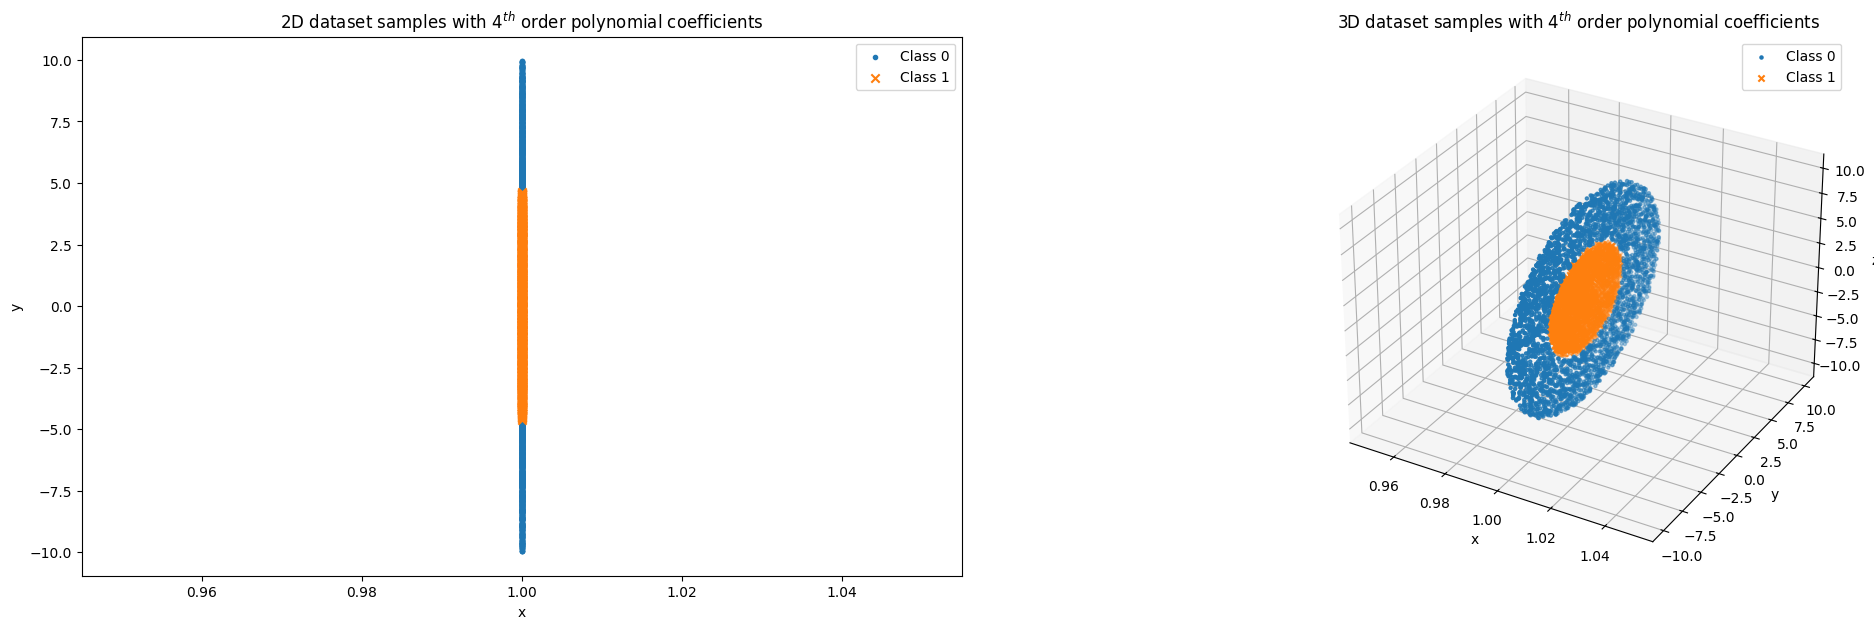

In [8]:
fig = plt.figure(figsize=(25, 7))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(class0[:, 0].cpu().numpy(), class0[:, 1].cpu().numpy(), label="Class 0", marker='.')
ax1.scatter(class1[:, 0].cpu().numpy(), class1[:, 1].cpu().numpy(), label="Class 1", marker='x')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title("2D dataset samples with $4^{th}$ order polynomial coefficients")
ax1.legend()


ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.scatter(class0[:, 0].cpu().numpy(), class0[:, 1].cpu().numpy(), class0[:, 2].cpu().numpy(), label="Class 0", marker='.')
ax1.scatter(class1[:, 0].cpu().numpy(), class1[:, 1].cpu().numpy(), class1[:, 2].cpu().numpy(), label="Class 1", marker='x')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title("3D dataset samples with $4^{th}$ order polynomial coefficients")
ax1.legend()

### Define single layer perceptron class
* Neuron number: 1
* Number of inputs: 2
* Activation function: Sigmoid

In [9]:
class single_layer_perceptron(nn.Module):
    def __init__(self, input_size):
        super(single_layer_perceptron, self).__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

### initialize parameters of model
* Number of epochs: 500
* Learning rate: 0.01
* Loss function: Mean Squared Error
* Optimizer: Stochastic Gradient Descent

In [10]:
model = single_layer_perceptron(X_train.size(1)).to(device) # create model
epochs = 500

# define loss function and optimizer
criterion = nn.MSELoss() # unsing mean squared error for loss function
optimizer = optim.SGD(model.parameters(), lr=0.01) # using stochastic gradient descent for optimization

# convert labels to integer type
y_train = y_train.long()
y_test = y_test.long()
y_val = y_val.long()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

### train phase

In [11]:
for epoch in range(epochs):
    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train.float())

    # backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # calculate accuracy
    predicted = torch.round(outputs.data)
    correct = (predicted == y_train).sum().item()
    train_accuracy = correct / y_train.size(0)
    train_f1 = f1_score(y_train.cpu().numpy(), predicted.cpu().numpy())

    # calculate loss and accuracy for validation set
    val_outputs = model(X_val)
    val_loss = criterion(val_outputs, y_val.float())
    val_predicted = torch.round(val_outputs.data)
    val_correct = (val_predicted == y_val).sum().item()
    val_accuracy = val_correct / y_val.size(0)
    val_f1 = f1_score(y_val.cpu().numpy(), val_predicted.cpu().numpy())

    # store losses and accuracies
    train_losses.append(loss.item())
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}")
print('-'*80)
print(f"Validation Loss: {sum(val_losses) / len(val_losses):.4f}, Validation Accuracy: {sum(val_accuracies) / len(val_accuracies):.4f}, Validation F1 Score: {val_f1:.4f}")
print("-"*80)

Epoch 1/500, Loss: 0.5245, Accuracy: 0.4521, F1 Score: 0.3636
Epoch 2/500, Loss: 0.5231, Accuracy: 0.4530, F1 Score: 0.3626
Epoch 3/500, Loss: 0.5208, Accuracy: 0.4559, F1 Score: 0.3619
Epoch 4/500, Loss: 0.5207, Accuracy: 0.4559, F1 Score: 0.3619
Epoch 5/500, Loss: 0.5201, Accuracy: 0.4565, F1 Score: 0.3617
Epoch 6/500, Loss: 0.5184, Accuracy: 0.4581, F1 Score: 0.3609
Epoch 7/500, Loss: 0.5183, Accuracy: 0.4581, F1 Score: 0.3609
Epoch 8/500, Loss: 0.5183, Accuracy: 0.4578, F1 Score: 0.3603
Epoch 9/500, Loss: 0.5180, Accuracy: 0.4584, F1 Score: 0.3606
Epoch 10/500, Loss: 0.5179, Accuracy: 0.4584, F1 Score: 0.3606
Epoch 11/500, Loss: 0.5177, Accuracy: 0.4597, F1 Score: 0.3611
Epoch 12/500, Loss: 0.5176, Accuracy: 0.4600, F1 Score: 0.3617
Epoch 13/500, Loss: 0.5176, Accuracy: 0.4600, F1 Score: 0.3617
Epoch 14/500, Loss: 0.5175, Accuracy: 0.4597, F1 Score: 0.3611
Epoch 15/500, Loss: 0.5175, Accuracy: 0.4597, F1 Score: 0.3611
Epoch 16/500, Loss: 0.5174, Accuracy: 0.4600, F1 Score: 0.3612
E

### plot train and validation loss and accuracy

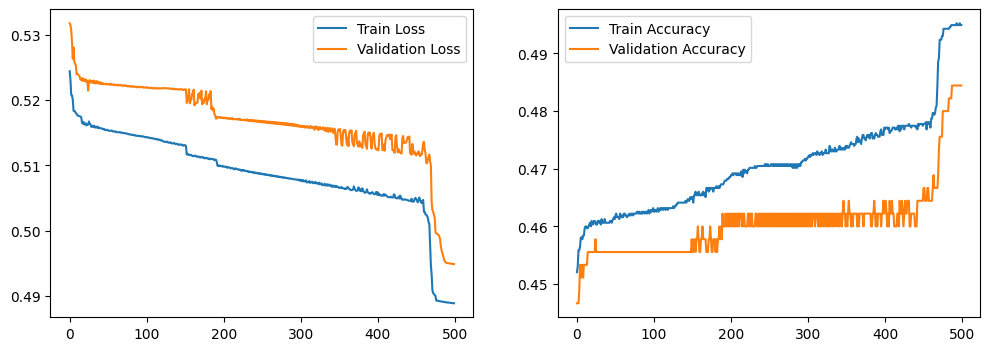

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.legend()

### test phase

In [13]:
test_outputs = model(X_test)
test_loss = criterion(test_outputs, y_test.float())
test_predicted = torch.round(test_outputs.data)
test_correct = (test_predicted == y_test).sum().item()
test_accuracy = test_correct / y_test.size(0)
test_f1 = f1_score(y_test.cpu().numpy(), test_predicted.cpu().numpy())
test_cm = confusion_matrix(y_test.cpu().numpy(), test_predicted.cpu().numpy())


# calculate F1 score and confusion matrix for training and validation set
train_predicted = torch.round(model(X_train).data)
train_f1 = f1_score(y_train.cpu().numpy(), train_predicted.cpu().numpy())
train_cm = confusion_matrix(y_train.cpu().numpy(), train_predicted.cpu().numpy())
val_cm = confusion_matrix(y_val.cpu().numpy(), val_predicted.cpu().numpy())

print(f"Test loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")
print("Final weights:", model.fc.weight.data)

Test loss: 0.5271, Test Accuracy: 0.4556, Test F1 Score: 0.3718
Final weights: tensor([[-0.0076,  0.1363,  0.1950, -0.0310,  0.1818, -0.0550, -0.1191,  0.0098,
         -0.0858,  0.2467,  0.2740,  0.1114, -0.0028,  0.1657, -0.1999]],
       device='cuda:0')


### plot confusion matrices

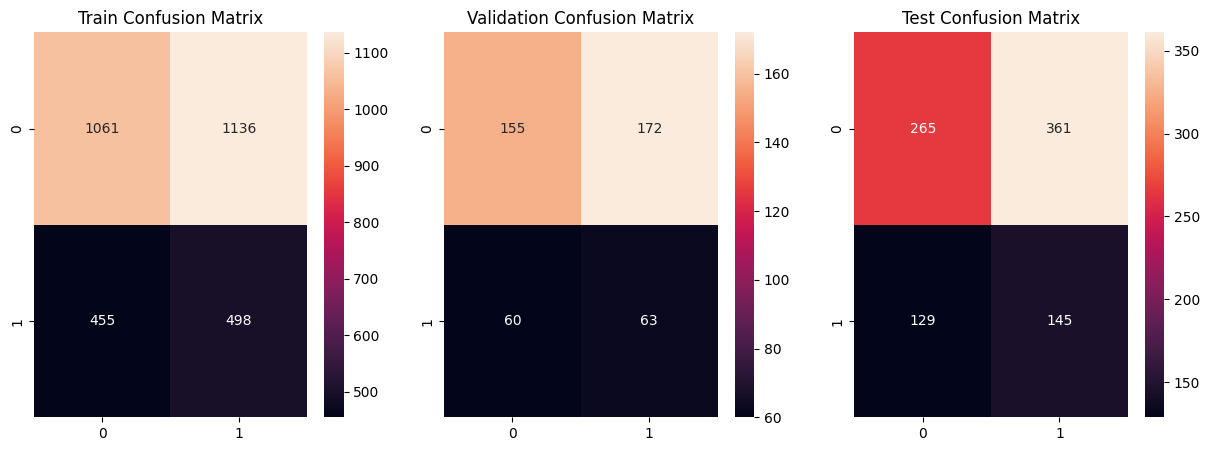

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(train_cm, annot=True, fmt='d', ax=axs[0])
axs[0].set_title("Train Confusion Matrix")

sns.heatmap(val_cm, annot=True, fmt='d', ax=axs[1])
axs[1].set_title("Validation Confusion Matrix")

sns.heatmap(test_cm, annot=True, fmt='d', ax=axs[2])
axs[2].set_title("Test Confusion Matrix")

plt.show()